## 📊 RQ1: Availability Analysis

In [24]:
# Imports
from   dotenv   			import load_dotenv
import matplotlib.pyplot 	as plt
import seaborn 				as sns
import pandas   			as pd
import datetime
import ast
import os

# Custom Imports
import sys
sys.path.append('../')
import AppUtils 	

##### Parameters

In [25]:
TMP_PATH = "../../0_Data/TMP/"

#### Initialization

In [26]:
print("⚡ START: {} ⚡".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")))
initTime = datetime.datetime.now()

⚡ START: 2025-06-05 18:47:16 ⚡


In [27]:
# Create TMP Folder
if not os.path.exists(TMP_PATH):
    os.makedirs(TMP_PATH)
    print("--- 📁🆕 Folder created       : {}\n".format(TMP_PATH))
else:
    print("--- 📁✅ Folder already exists: {}\n".format(TMP_PATH))

--- 📁✅ Folder already exists: ../../0_Data/TMP/



In [28]:
# Load .env Info
load_dotenv()

True

#### 📥 1) Load Data

In [29]:
# Specify the data path
DATA_PATH = '../../0_Data/1_appsAvailabilityByCountry.csv'

# Read the CSV file into a pandas dataframe
appsDF = pd.read_csv(DATA_PATH)

print("--- #️⃣ Number of apps: {}".format(appsDF.shape[0]))

--- #️⃣ Number of apps: 73756


In [30]:
appsDF.head(5)

,sha256,pkgName,Luxembourg,Santiago,Sydney,TelAviv,Tokyo,LosAngeles,Johannesburg
0,B44C651BF81A8331ED17FF8B763EE62C63036DFF160C2A...,MortgageRefinancingPRO_Market.DPsoftware.org,True,True,True,True,True,True,True
1,A853007A4F7FDE328C6732011B94DB848DE4BB8FB0BEE2...,a.levelclass,True,True,True,True,True,True,True
2,FCA3AA578ECB23F933FEA4D39CDDB7EED53B2F5DCE9C16...,a2z.Mobile.Event6390,404,404,404,404,404,404,404
3,0796E815B58BDFC497053139397645F0069C9BD42E7D7B...,a2z.Mobile.Event6394,True,True,True,True,True,True,True
4,E74AEC71195C7C1EBAB9601A4217C0DDE0130BD665B542...,a2z.Mobile.Event6407,True,True,True,True,True,True,True


### 🛠️ 2) Preprocess Data

In [31]:
# Get the list of locations from the columns
locationsList = appsDF.columns[2:].to_list()
print("--- 🌍 Locations: {}".format(locationsList))

--- 🌍 Locations: ['Luxembourg', 'Santiago', 'Sydney', 'TelAviv', 'Tokyo', 'LosAngeles', 'Johannesburg']


In [32]:
# Apply ast.literal_eval to every column except the first one
for col in appsDF.columns[2:]:
    appsDF[col] = appsDF[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Replace '404' string with 404 number
appsDF.replace('404', 404, inplace=True)

In [33]:
# Count the number of rows where at least one column (except the first) has a '404' value
numAtLeastOne404 = (appsDF.iloc[:, 2:] == 404).any(axis=1).sum()

# Count the number of rows where all columns (except the first) are equal to False
numAllFalse = (appsDF.iloc[:, 2:] == False).all(axis=1).sum()

# Count the number of rows where all columns (except the first) are equal to True
numAllTrue = (appsDF.iloc[:, 2:] == True).all(axis=1).sum()

# Print the numbers in a nicely formatted way with emoji
print("--- ✅ Number of apps with all location are True : {}".format(numAllTrue))
print("--- ❌ Number of apps with all location are False: {}".format(numAllFalse))
print("--- ⚠️ Number of apps with at least one 404      : {}".format(numAtLeastOne404))

# Remove rows with all locations as False, at least one 404, or all True
appsDF = appsDF[~((appsDF.iloc[:, 2:] == False).all(axis=1) | (appsDF.iloc[:, 2:] == 404).any(axis=1) | (appsDF.iloc[:, 2:] == True).all(axis=1))]

# Print the number of remaining apps
print("--- #️⃣ Number of remaining apps                  : {}".format(appsDF.shape[0]))

--- ✅ Number of apps with all location are True : 48178
--- ❌ Number of apps with all location are False: 143
--- ⚠️ Number of apps with at least one 404      : 12210
--- #️⃣ Number of remaining apps                  : 13225


### 🌍 3) Create invididual DFs for app available only in a certain location.

In [34]:
# Get apps that can be downloaded in only one location
dfsPerLocation = {}

for location in locationsList:
    if location in appsDF.columns:
        # Create a dataframe where the location is True and all other locations are False
        df = appsDF[(appsDF[location] == True) & (appsDF[locationsList].sum(axis=1) == 1)]
        dfsPerLocation[location] = df

        # Save the dataframe to a CSV file
        #df.to_csv(f"{TMP_PATH}appsExclusive_{location}.csv", index=False)

for location, df in dfsPerLocation.items():
    print("--- 📍 {:<12}: {:<5} Unique Pkg Names".format(location, df.shape[0]))

--- 📍 Luxembourg  : 275   Unique Pkg Names
--- 📍 Santiago    : 687   Unique Pkg Names
--- 📍 Sydney      : 1014  Unique Pkg Names
--- 📍 TelAviv     : 585   Unique Pkg Names
--- 📍 Tokyo       : 5807  Unique Pkg Names
--- 📍 LosAngeles  : 1718  Unique Pkg Names
--- 📍 Johannesburg: 599   Unique Pkg Names


In [35]:
# Parameters
SMALL_SIZE  = 16
MEDIUM_SIZE = 18
LARGE_SIZE  = 20

COLORS  = ["#89CFFD", '#FF8282', '#C084FC', '#FFE066', '#90C67C','#FFB347', '#60B5FF'  ]

PLOTS_PATH = "./0_Data/Plots/"

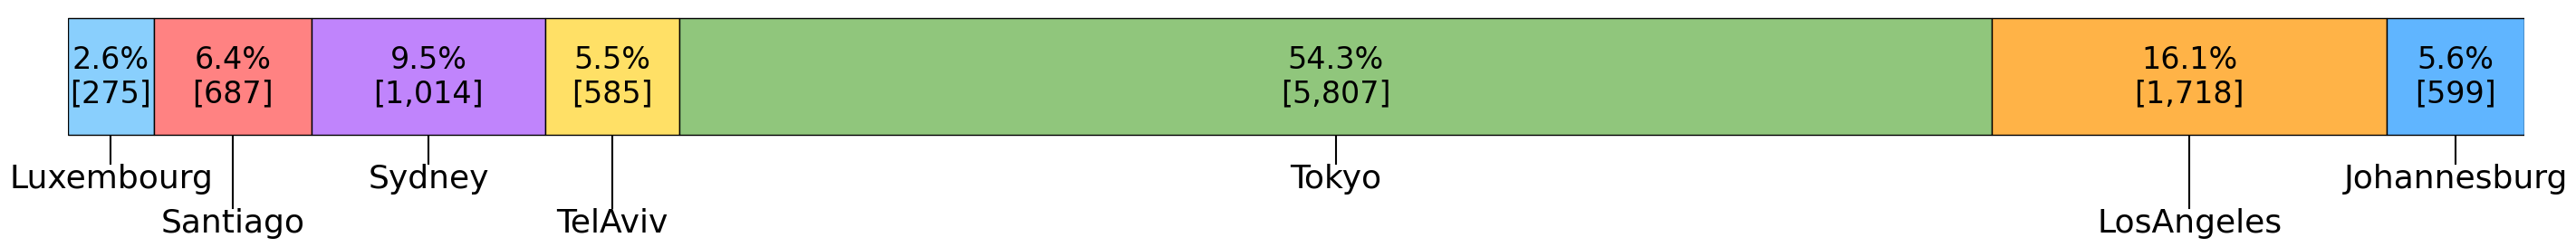

In [36]:
# Your data
locations = list(dfsPerLocation.keys())
numUniquePkgNames = [df.shape[0] for df in dfsPerLocation.values()]

# Compute total and percentages
totalApps = sum(numUniquePkgNames)
percentages = [count / totalApps * 100 for count in numUniquePkgNames]

# --- Plot ---
plt.figure(figsize=(35, 3))
ax = plt.gca()
ax.axis('off')

# Plot each location as a stacked bar
for i in range(len(locations)):
    left = sum(numUniquePkgNames[:i])
    width = numUniquePkgNames[i]
    color = COLORS[i % len(COLORS)]
    
    # Bar segment
    if locations[i] == 'Luxembourg':
        width += 100
    if locations[i] in ['Santiago', 'Sydney', 'TelAviv', 'Tokyo']:
        left += 100
    if locations[i] == 'Tokyo':
        width -= 100
    ax.barh(0, width, left=left, edgecolor='black', color=color)

    # Label position
    textX = left + width / 2
    textY = -0.7 if i % 2 == 0 else -1

    # Location label
    ax.text(textX, textY, locations[i], ha='center', va='center', fontsize=26)

    # Percentage + count
    ax.text(textX, 0, '{:.1f}%\n[{:,}]'.format(percentages[i], numUniquePkgNames[i]),
            ha='center', va='center', fontsize=24)

    # Leader line
    ax.plot([textX, textX], [-0.41, textY + 0.1], color='black')

# Adjust x-axis
ax.set_xlim(0, totalApps)

# Save
plt.savefig(PLOTS_PATH + 'rq1_appsPerLocation.png', dpi=300, bbox_inches='tight')
plt.savefig(PLOTS_PATH + 'rq1_appsPerLocation.pdf', bbox_inches='tight')

plt.show()

### 🔍 4) Analysis

App available exclusively in X countries.

In [37]:
# Initialize a list to store the percentages
percentages = []

totalApps = appsDF.shape[0]

# Total number of apps including those with all locations True
totalAppsIncludingAllTrue = totalApps + numAllTrue

# Iterate through the number of countries
for i in range(1, len(locationsList)):
    # Count the number of apps downloadable in exactly 'i' countries
    count = appsDF[appsDF[locationsList].sum(axis=1) == i].shape[0]
    # Calculate the percentage
    percentage = (count / totalAppsIncludingAllTrue) * 100
    percentages.append((i, percentage))
    # Print the count and percentage for each iteration
    print("--- ⭕ {:<2} country(ies) --> [{:>5.2f}%] -- [{:>5}/{}] of apps downloadable.".format(i, percentage, count, totalAppsIncludingAllTrue))

# Calculate and print the percentage of apps downloadable in all locations
percentageAllTrue = (numAllTrue / totalAppsIncludingAllTrue) * 100
print("--- ⭕ All locations   --> [{:>5.2f}%] -- [{:>5}/{}] of apps downloadable.".format(percentageAllTrue, numAllTrue, totalAppsIncludingAllTrue))

--- ⭕ 1  country(ies) --> [17.40%] -- [10685/61403] of apps downloadable.
--- ⭕ 2  country(ies) --> [ 1.64%] -- [ 1007/61403] of apps downloadable.
--- ⭕ 3  country(ies) --> [ 0.60%] -- [  370/61403] of apps downloadable.
--- ⭕ 4  country(ies) --> [ 0.32%] -- [  198/61403] of apps downloadable.
--- ⭕ 5  country(ies) --> [ 0.29%] -- [  179/61403] of apps downloadable.
--- ⭕ 6  country(ies) --> [ 1.27%] -- [  779/61403] of apps downloadable.
--- ⭕ All locations   --> [78.46%] -- [48178/61403] of apps downloadable.


##### 🔚 End

In [38]:
endTime = datetime.datetime.now()
print("\n🔚 --- END:  {} --- 🔚".format(endTime.strftime("%Y-%m-%d %H:%M:%S")))

# Assuming endTime and initTime are datetime objects
totalTime = endTime - initTime
hours     = totalTime.total_seconds() // 3600
minutes   = (totalTime.total_seconds() % 3600) // 60
seconds   = totalTime.total_seconds() % 60
print("⏱️ --- Time: {:02d} hours and {:02d} minutes [{:02d} seconds] --- ⏱️".format(int(hours), int(minutes), int(totalTime.total_seconds())))


🔚 --- END:  2025-06-05 18:47:17 --- 🔚
⏱️ --- Time: 00 hours and 00 minutes [01 seconds] --- ⏱️
